Modality (01 = full-AV, 02 = video-only, 03 = audio-only).<br/>
Vocal channel (01 = speech, 02 = song).<br/>
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).<br/>
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.<br/>
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").<br/>
Repetition (01 = 1st repetition, 02 = 2nd repetition).<br/>
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).<br/>

In [6]:
emotion_map = {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : 
                 "fearful", "07" : "disgust", "08" : "surprised"}
# emotion_map_int = {int(i) : j for i, j in emotion_map.items()}
# emotion_map_rev = {j : int(i) for i, j in emotion_map.items()}

In [3]:
import librosa
from librosa import display

from IPython.display import Audio
from glob import glob
import joblib

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Conv1D, Flatten, Dropout, Activation, BatchNormalization, LSTM, InputLayer, Reshape
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
from time import time


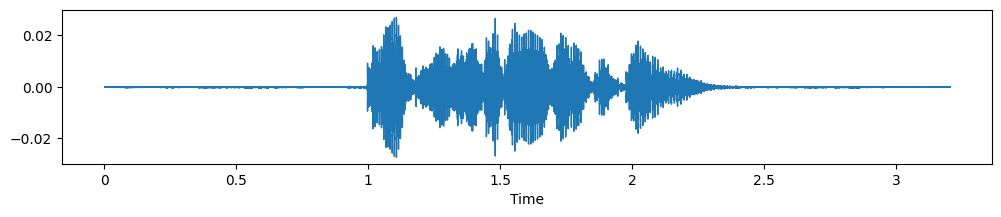

In [4]:
# Pick a random file and observe the data
base_path = "C:/Users/ajayd/Home/Assignments/Final Assignment/"
random_audio = np.random.choice(glob(base_path + 'Audio Speech Actors/*/*'))
audio, sr = librosa.load(random_audio, res_type='kaiser_fast')
plt.figure(figsize = (12,2))
librosa.display.waveshow(audio, sr = sr)
Audio(random_audio)

In [8]:
dataset = []

for file_name in tqdm(glob(base_path + 'Audio Speech Actors/*/*')):
    Emotion = file_name.split('\\')[-1].strip('.wav').split('-')[2]
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfcc = np.mean(mfcc, axis = 1)
    dataset.append([mfcc, emotion_map.get(Emotion)])

for file_name in tqdm(glob(base_path + 'TESS Toronto Emotional Speech/*/*')):
    Emotion = file_name.split('\\')[-2].split('_')[-1].lower()
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfcc = np.mean(mfcc, axis = 1)
    dataset.append([mfcc, Emotion])

    
data = pd.DataFrame(dataset, columns = ['audio_features_mfcc', 'emotion'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [01:20<00:00, 29.80it/s]


In [9]:
data.head()

,audio_features_mfcc,emotion
0,"[-700.04803, 58.141853, -2.5586066, 15.606677,...",neutral
1,"[-695.1851, 58.72073, -4.8757935, 19.315145, 5...",neutral
2,"[-693.6901, 61.060158, -2.8490763, 16.58725, 2...",neutral
3,"[-687.24304, 58.965412, -0.27530542, 16.264652...",neutral
4,"[-729.57996, 65.91619, -0.40742582, 18.537952,...",calm


In [10]:
data.groupby("emotion").count()

,audio_features_mfcc
emotion,
angry,592
calm,190
disgust,592
fear,400
fearful,192
happy,592
neutral,496
sad,592
surprised,191


In [11]:
df = pd.DataFrame(data.audio_features_mfcc.tolist()).fillna(0.0)
df['emotion'] = data['emotion'].replace({'fearful' : 'fear', 'surprised': 'other', 'calm' : 'other'})
del data
df = df[df.emotion.isin(['angry', 'happy', 'sad', 'neutral', 'other'])]
df.to_csv('./data.csv', index = False)

In [12]:
df = pd.read_csv('data.csv')

In [13]:
encoder = LabelEncoder()
df['emotion'] = encoder.fit_transform(df['emotion'])

In [14]:
joblib.dump(encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['emotion']), df['emotion'], 
                                                        test_size=0.33, random_state=42)

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

model = Sequential()
model.add(Conv1D(64, 5, padding='same',
                 input_shape=(40, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(len(encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

cnn_history = model.fit(x_traincnn, y_train,
                       batch_size=32, epochs=75,
                       validation_data=(x_testcnn, y_test))


C:\Users\ajayd\Home\github_repositories\Speech-Emotion-Recognition\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 40, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 40, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 40, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 40, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │          12,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,325 (376.27 KB)

 Trainable params: 95,813 (374.27 KB)

 Non-trainable params: 512 (2.00 KB)

None
Epoch 1/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5281 - loss: 1.6390 - val_accuracy: 0.5696 - val_loss: 1.1860
Epoch 2/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7207 - loss: 0.8357 - val_accuracy: 0.7477 - val_loss: 0.8557
Epoch 3/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7491 - loss: 0.6711 - val_accuracy: 0.7717 - val_loss: 0.6059
Epoch 4/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7702 - loss: 0.6310 - val_accuracy: 0.7740 - val_loss: 0.6431
Epoch 5/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7792 - loss: 0.6063 - val_accuracy: 0.7957 - val_loss: 0.5618
Epoch 6/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7902 - loss: 0.5438 - val_accuracy: 0.7957 - val_loss: 0.5075
Epoch 7/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7722 - loss: 0.5460 - val_accuracy: 0.7979 - val_loss: 0.4912
Epoch 8/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7951 - loss: 0.5402 - val_accuracy: 0.760

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9230 - loss: 0.1757 - val_accuracy: 0.8596 - val_loss: 0.4070
Epoch 52/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9370 - loss: 0.1588 - val_accuracy: 0.8653 - val_loss: 0.4226
Epoch 53/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9206 - loss: 0.2102 - val_accuracy: 0.8664 - val_loss: 0.4367
Epoch 54/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9320 - loss: 0.1734 - val_accuracy: 0.8527 - val_loss: 0.4351
Epoch 55/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9325 - loss: 0.1792 - val_accuracy: 0.8596 - val_loss: 0.4166
Epoch 56/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9352 - loss: 0.1868 - val_accuracy: 0.8539 - val_loss: 0.4195
Epoch 57/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9382 - loss: 0.1609 - val_accuracy: 0.8710 - val_loss: 0.3950
Epoch 58/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9476 - loss: 0.1410 - val_accuracy: 0.8721 - val_l

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


              precision    recall  f1-score   support

       angry       0.95      0.91      0.93       185
       happy       0.89      0.90      0.89       191
     neutral       0.96      0.89      0.92       171
       other       0.69      0.81      0.75       133
         sad       0.91      0.88      0.89       196

    accuracy                           0.88       876
   macro avg       0.88      0.88      0.88       876
weighted avg       0.89      0.88      0.88       876



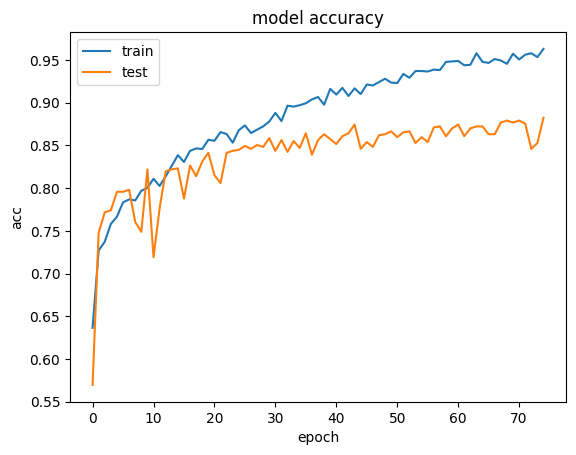

In [16]:
# Loss plotting
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.close()

# Accuracy plotting
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png')

predictions = encoder.inverse_transform(model.predict(x_testcnn).argmax(axis=1))
new_y_test = encoder.inverse_transform(y_test)
matrix = confusion_matrix(new_y_test, predictions)

print(classification_report(new_y_test, predictions))

model_name = 'Emotion_Voice_Detection_Model.h5'
model.save(model_name)

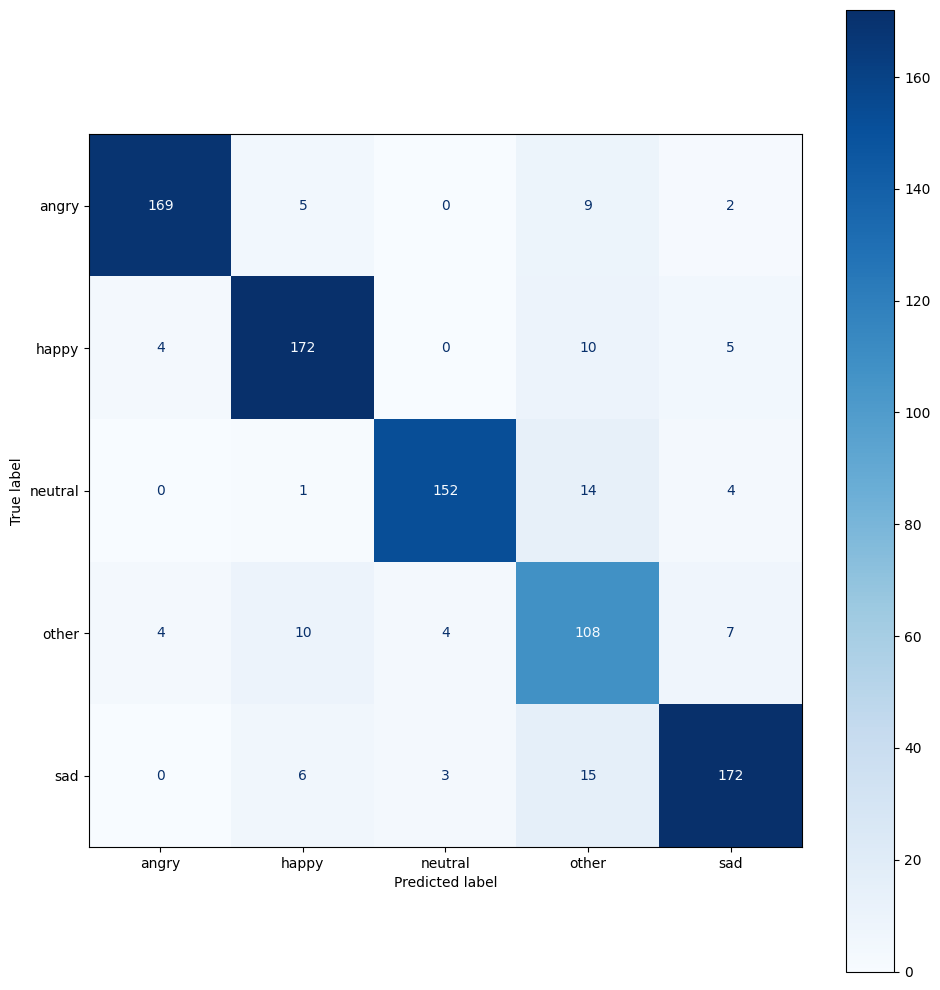

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes(111)
ConfusionMatrixDisplay.from_predictions(new_y_test, predictions, display_labels=encoder.classes_, ax=ax, cmap="Blues")
plt.tight_layout()
plt.show()